# Autoencoders

In [7]:
import warnings
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.regularizers import L1L2
from keras.datasets import mnist

### Using GPU, if CUDA lets me...

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

## Simple autoencoder

In [15]:
def create_dense_ae():
    # Encoded representation dimesion
    encoding_dim = 49

    # Encoder
    # Input placeholder
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - sizes of rows, cols, filters of 1 image
    # Utility reshape layer
    flat_img = Flatten()(input_img)
    # Encode with dense layer -> representation
    encoded = Dense(encoding_dim, activation="relu")(flat_img)
    
    # Decoder
    # Decode with dense layer -> image
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation="sigmoid")(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    #                 input     other
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                38465     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2524 - val_loss: 0.1700
Epoch 2/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1526 - val_loss: 0.1357
Epoch 3/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1269 - val_loss: 0.1165
Epoch 4/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1118 - val_loss: 0.1050
Epoch 5/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1022 - val_loss: 0.0973
Epoch 6/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0956 - val_loss: 0.0919
Epoch 7/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0909 - val_loss: 0.0878
Epoch 8/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0874 - val_loss: 0.0850
Epoch 9/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0849 - val_loss: 0.0830
Epoch 10/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0833 - val_loss: 0.0817

### Plotter function

In [17]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

1/1 [==============================] - 0s 34ms/step


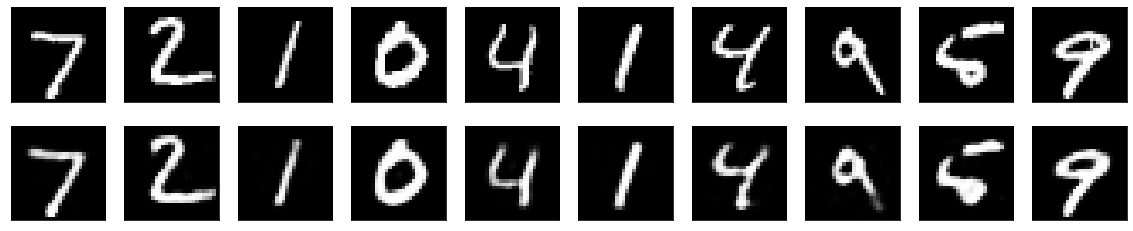

In [18]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)

decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

## Deep AE

In [21]:
def create_deep_dense_ae():
    # Encoded representation dimension
    encoding_dim = 49

    # Encoder
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation="relu")(flat_img)
    x = Dense(encoding_dim*2, activation="relu")(x)
    encoded = Dense(encoding_dim, activation='linear')(x)
    
    # Decoder
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation="relu")(input_encoded)
    x = Dense(encoding_dim*3, activation="relu")(x)
    flat_decoded = Dense(28*28, activation="sigmoid")(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Models
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()
d_autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

d_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 49)                134750    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         135485    
                                                                 
Total params: 270,235
Trainable params: 270,235
Non-trainable params: 0
_________________________________________________________________


In [22]:
d_autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.2238 - val_loss: 0.1472
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1328 - val_loss: 0.1210
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1161 - val_loss: 0.1092
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1070 - val_loss: 0.1045
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1020 - val_loss: 0.0988
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0984 - val_loss: 0.0960
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0959 - val_loss: 0.0940
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0938 - val_loss: 0.0919
Epoch 9/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0919 - val_loss: 0.0903
Epoch 10/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0904 - val_lo

1/1 [==============================] - 0s 56ms/step


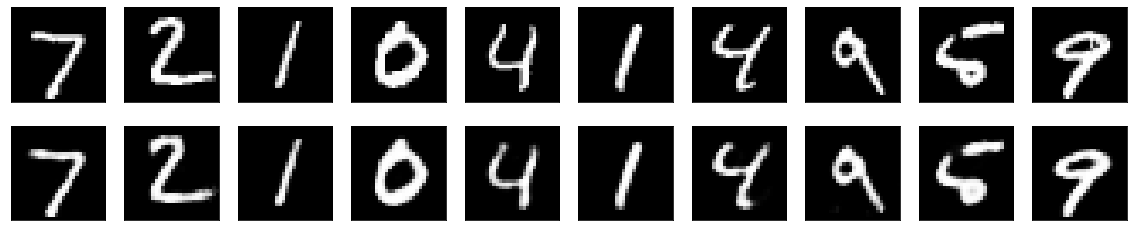

In [23]:
n = 10

imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)


## Deep convolutional AE

In [24]:
def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation="relu", padding="same")(input_img)
    x = MaxPooling2D((2, 2), padding="same")(x)
    x = Conv2D(32, (2, 2), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2), padding="same")(x)
    encoded = Conv2D(1, (7, 7), activation="relu", padding="same")(x)

    # Here the representation is (7, 7, 1), dim=49

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation="relu", padding="same")(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation="sigmoid", padding="same")(x)

    # Models
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 1)           24385     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         24385     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

## Denoising AE

In [19]:
batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer="adam", loss="binary_crossentropy")

denoiser_model.summary()

Model: "denoiser"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(16, 28, 28, 1)]         0         
                                                                 
 noiser (Functional)         (16, 28, 28, 1)           0         
                                                                 
 autoencoder (Functional)    (None, 28, 28, 1)         77665     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoiser_model.fit(x_train, x_train,
                   epochs=200,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

1/1 [==============================] - 0s 14ms/step


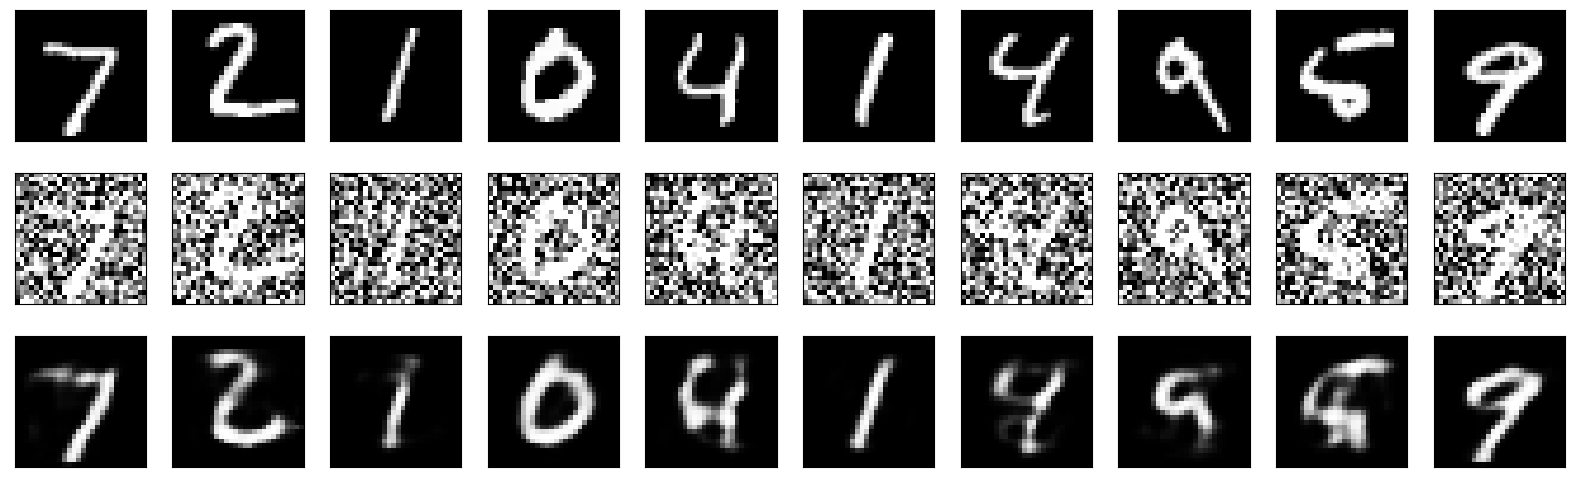

In [16]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

## Sparse AE

In [24]:
def create_sparse_ae():
    encoding_dim = 16
    lambda_l1 = 0.00001
    
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation="relu")(flat_img)
    x = Dense(encoding_dim*2, activation="relu")(x)
    encoded = Dense(encoding_dim, activation="linear", activity_regularizer=L1L2(lambda_l1))(x)
    
    # Decoder
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation="relu")(input_encoded)
    x = Dense(encoding_dim*3, activation="relu")(x)
    flat_decoded = Dense(28*28, activation="sigmoid")(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Models
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

s_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                39776     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         40544     
                                                                 
Total params: 80,320
Trainable params: 80,320
Non-trainable params: 0
_________________________________________________________________


In [25]:
s_autoencoder.fit(x_train, x_train,
                epochs=400,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/400
235/235 [==============================] - 1s 3ms/step - loss: 0.2900 - val_loss: 0.2225
Epoch 2/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1928 - val_loss: 0.1688
Epoch 3/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1612 - val_loss: 0.1538
Epoch 4/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1520 - val_loss: 0.1476
Epoch 5/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1465 - val_loss: 0.1423
Epoch 6/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1419 - val_loss: 0.1387
Epoch 7/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1386 - val_loss: 0.1357
Epoch 8/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1354 - val_loss: 0.1327
Epoch 9/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1327 - val_loss: 0.1297
Epoch 10/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1298 - val_lo

Epoch 161/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1037 - val_loss: 0.1030
Epoch 162/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1037 - val_loss: 0.1030
Epoch 163/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1030
Epoch 164/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1037 - val_loss: 0.1030
Epoch 165/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1029
Epoch 166/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1028
Epoch 167/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1029
Epoch 168/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1030
Epoch 169/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1036 - val_loss: 0.1029
Epoch 170/400
235/235 [==============================] - 1s 3ms/step - lo

235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - val_loss: 0.1019
Epoch 320/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1024 - val_loss: 0.1019
Epoch 321/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1024 - val_loss: 0.1019
Epoch 322/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1024 - val_loss: 0.1017
Epoch 323/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1024 - val_loss: 0.1019
Epoch 324/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - val_loss: 0.1019
Epoch 325/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - val_loss: 0.1019
Epoch 326/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - val_loss: 0.1018
Epoch 327/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - val_loss: 0.1019
Epoch 328/400
235/235 [==============================] - 1s 3ms/step - loss: 0.1023 - v

1/1 [==============================] - 0s 13ms/step


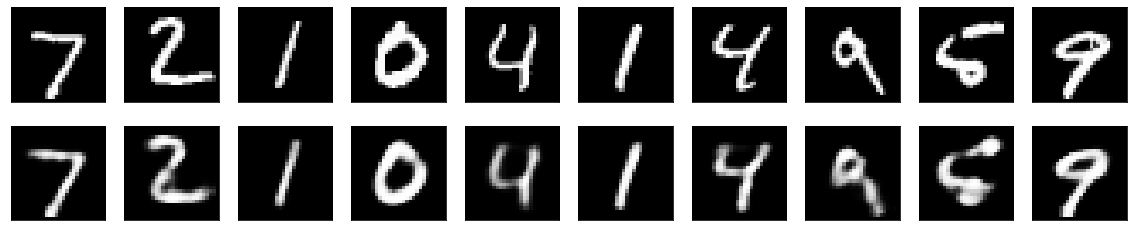

In [27]:
n = 10

imgs = x_test[:n]
encoded_imgs = s_encoder.predict(imgs, batch_size=n)

decoded_imgs = s_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)